No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

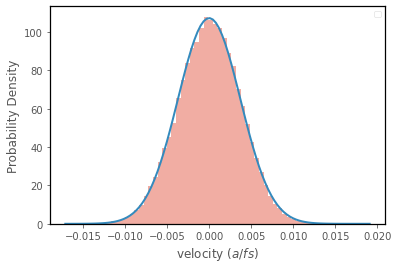

In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import norm
import seaborn as sns
import torch
path = './0_water_distribution/dump/'
file = 'velocity_position_nvt.out'
header =2

# TimeStep v_vcmx v_vcmy v_vcmz v_xcmx v_xcmy v_xcmz
#     0      1       2      3      4      5      6      
data = []
fname = os.path.join(path,file)  # read in file path
num_timeframe = 0 
with open(fname, 'r') as fo:
    for n in range(header):
            next(fo)  
    for line in fo:
        if 'Loop' in line:
            break
        info = line.split()
        data.append(info)
        num_timeframe += 1    
data = np.asfarray(data, dtype=np.float64).reshape(num_timeframe,-1)   

#%%

plt.style.use('ggplot')
plt.tight_layout()
fig, ax = plt.subplots()  

r1 = 1
r2 = 2
r3 = 3

free_x = data[:,r1]
free_y = data[:,r2]
free_z = data[:,r3]

onev = free_x
    
sample_mean = np.mean(onev)
sample_std = np.std(onev)

dist = norm(sample_mean, sample_std)

(mean, std) = norm.fit(onev)

n, bins, patches = ax.hist(onev, 60,density = 1 , alpha=0.45)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

ax.plot(x, p, linewidth=2)

ax.set_xlabel('velocity ($a/fs$)')

ax.set_ylabel('Probability Density')
ax.grid(False)
ax.set_facecolor('white')
ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k') 
ax.spines['right'].set_color('k')
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(1.25)
ax.spines['top'].set_linewidth(1.25) 
ax.spines['right'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
ax.legend(facecolor = 'white',loc='best', fontsize = 'small',ncol = 1)

In [2]:
import os

In [3]:
os.getcwd()

'/home/wenjie/gitcode/LSTM_atom_sequence/15_water_distribution'

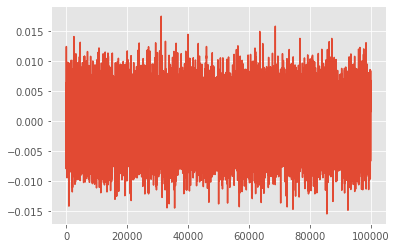

In [4]:
plt.plot(onev)

In [5]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler


In [6]:
vel_series = pd.Series(onev)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

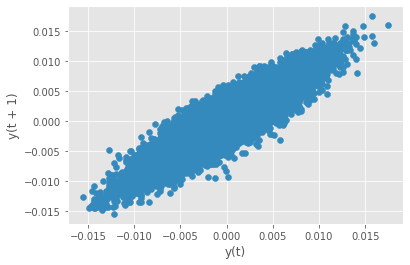

In [7]:
pd.plotting.lag_plot(vel_series)

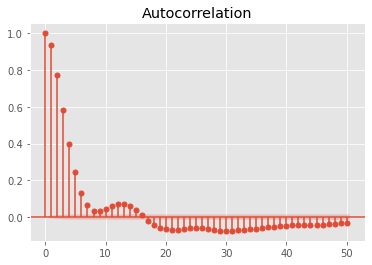

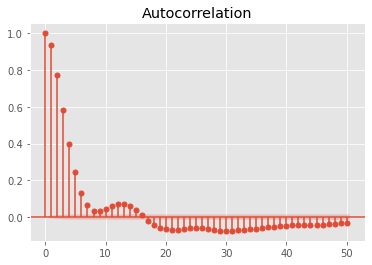

In [8]:
plot_acf(vel_series, lags=50)

In [9]:
scaler = StandardScaler()
print(scaler.fit(onev.reshape(-1,1)))

StandardScaler()


In [10]:
normalized_vel = scaler.transform(onev.reshape(-1,1))

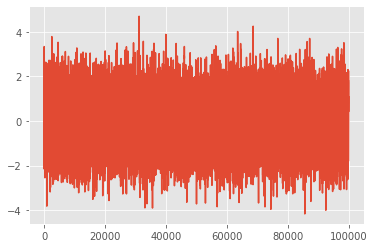

In [11]:
plt.plot(normalized_vel)

In [12]:
num_bins=600
sm_length=3
threshold=100

# x-values of the metastable states in the 4-state model potential.
X=np.linspace(-5,5,num=num_bins).tolist()

# Labels of all possible states in the ranges we considered.
# For 2d systems, this is not the same as the number of representative values.
all_combs = [i for i in range(num_bins)]
vocab=sorted(all_combs)
vocab_size = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)} # Mapping from characters to indices
idx2char = np.array(vocab)

# Sequence length and shift in step between past (input) & future (output)
seq_length = 100
shift=1

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset.
BUFFER_SIZE = 50000

# Model parameters
embedding_dim = 8
rnn_units = 64

# Training epochs
EPOCHS=2

In [13]:
def running_mean(x, N):
    """
    Convolution as running average. Smoothen data.
    """
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def find_nearest(key_arr, target):
    """
    key_arr: array-like, storing keys.
    target: the representative value which we want to be closest to.
    """
    idx=np.abs(key_arr-target).argmin()
    return idx

def Rm_peaks_steps(traj, threshold):
    """
    Remove sudden changes in the trajectory such as peaks and small steps.
    Here the gradient is used to identify the changes. If two nonzero
    gradients are too close (< threshold), we treat it as noise.
    """
    traj=np.array(traj)
    grad_traj=np.gradient(traj) # gradient of trajectory
    idx_grad=np.where(grad_traj!=0)[0] # the index of nonzero gradient.
    idx0=idx_grad[0]
    for idx in idx_grad:
        window=idx-idx0
        if window <= 1: # neighbor
            continue
        elif window > 1 and window <= threshold:
            traj[idx0:idx0+window//2+1]=traj[idx0]
            traj[idx0+window//2+1:idx+1]=traj[idx+1]
            idx0=idx
        elif window > threshold:
            idx0=idx
    return traj

def split_input_target(chunk):
    """
    split sequences into input and target.
    """
    input_text = chunk[:-shift]
    target_text = chunk[shift:]
    return input_text, target_text

In [14]:
#input_x = running_mean(normalized_vel.reshape(-1), sm_length)
input_x = normalized_vel.reshape(-1)

In [15]:
input_x = normalized_vel.reshape(-1)

In [16]:
len(input_x)

100001

In [17]:
idx_x = map(lambda x : find_nearest(X, x), input_x)
idx_2d = list(idx_x)
text = idx_2d
text_as_int = np.array([char2idx[c] for c in text])

In [18]:
def convert2datalist(arr, seq_len):
    x=[]
    y=[]
    
    for i in range(len(arr)-seq_len):
        x_i = arr[i:i+seq_len]
        y_i = arr[i+1:i+seq_len+1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = torch.autograd.Variable(torch.from_numpy(x_arr).float())
    y_var = torch.autograd.Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [19]:
x, y = convert2datalist(text, 3000)

In [22]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(torch.Tensor(x[:-10000]).to(torch.int64),torch.Tensor(y[:-10000]).to(torch.int64))
train_dataloader = DataLoader(train_dataset,batch_size = 192, shuffle = True)
test_dataset = TensorDataset(torch.Tensor(x[-10000:]).to(torch.int64),torch.Tensor(y[-10000:]).to(torch.int64))
test_dataloader = DataLoader(test_dataset,batch_size = 192,shuffle = False)
for a,b in train_dataloader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([192, 3000])
torch.Size([192, 3000])


In [20]:
class RNN(torch.nn.Module):
    def __init__(self, index_size, hidden_size1, hidden_size2, output_size):
        super(RNN, self).__init__()
        self.emb = torch.nn.Embedding(index_size, hidden_size1)
        self.lstm = torch.nn.LSTM(hidden_size1, hidden_size2, dropout=0.2)
        
        self.fc = torch.nn.Linear(hidden_size2, output_size)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, input):
        embed = self.emb(input)
        pred, (h,c) = self.lstm(embed)
        
        result = self.fc(pred)
        #result = self.softmax(result)
        return result, (h, c)
        
        

In [21]:
model = RNN(600,24,48,600)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/wenjie/anaconda3/envs/newtorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNN(
  (emb): Embedding(600, 24)
  (lstm): LSTM(24, 48, dropout=0.2)
  (fc): Linear(in_features=48, out_features=600, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
for a, b in train_dataloader:
    print(a.shape)
    print(b.shape)
    pred, _ = model(a.transpose(0,1).to(device))
    print(pred.shape)
    break

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
#trian the model
epoches = 31

for epoch in range(epoches):
    model.train()
    LOSS = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x = x.to(torch.int64).transpose(0,1)
        x=x.to(device)
        y=y.to(torch.int64).transpose(0,1).to(device)
        
        pred, _ = model(x)
        
        loss = criterion(pred.reshape(-1,600), y.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        LOSS = LOSS+loss
        
    print('current epoch is {:3d}, erros is {:5f}'.format(epoch, LOSS))
    
    if epoch%10 == 0:
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for x, y in test_dataloader:
                x = x.to(torch.int64).transpose(0,1)
                x=x.to(device)
                y=y.to(torch.int64).transpose(0,1).to(device)

                pred, _ = model(x)

                loss = criterion(pred.reshape(-1,600), y.reshape(-1))

                test_loss +=loss
        
        print('current epoch is {:3d}, test erros is {:5f}'.format(epoch, test_loss))
    
        
        
        
        
        


current epoch is   0, erros is 2673.812744
current epoch is   0, test erros is 292.695068
current epoch is   1, erros is 2499.107666
current epoch is   2, erros is 2443.692871
current epoch is   3, erros is 2345.165283
current epoch is   4, erros is 2241.467773
current epoch is   5, erros is 2154.771240
current epoch is   6, erros is 2079.559082
current epoch is   7, erros is 2014.014526
current epoch is   8, erros is 1956.581299
current epoch is   9, erros is 1904.383667
current epoch is  10, erros is 1858.593872
current epoch is  10, test erros is 216.239822
current epoch is  11, erros is 1819.688477
current epoch is  12, erros is 1786.765625
current epoch is  13, erros is 1758.634888
current epoch is  14, erros is 1734.927368
current epoch is  15, erros is 1714.822754
current epoch is  16, erros is 1697.715332
current epoch is  17, erros is 1683.250244
current epoch is  18, erros is 1670.831055
current epoch is  19, erros is 1660.084229
current epoch is  20, erros is 1650.622314
cur

In [24]:
model.eval()
prediction = []
i, j = test_dataset[1]
i = i.unsqueeze(1).to(torch.int64).to(device)
with torch.no_grad():
    for m in range(50000):
        pred, _ = model(i)
        pred = model.softmax(pred)
        pred_id = torch.multinomial(pred[-1,0],1)
        
        
        prediction.append(pred_id)
        
        pred_id = pred_id.unsqueeze(1)
        
        i = torch.cat((i, pred_id), 0)[1:]
        
        if m%10 == 0:
            print(m)
        
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
1717

29170
29180
29190
29200
29210
29220
29230
29240
29250
29260
29270
29280
29290
29300
29310
29320
29330
29340
29350
29360
29370
29380
29390
29400
29410
29420
29430
29440
29450
29460
29470
29480
29490
29500
29510
29520
29530
29540
29550
29560
29570
29580
29590
29600
29610
29620
29630
29640
29650
29660
29670
29680
29690
29700
29710
29720
29730
29740
29750
29760
29770
29780
29790
29800
29810
29820
29830
29840
29850
29860
29870
29880
29890
29900
29910
29920
29930
29940
29950
29960
29970
29980
29990
30000
30010
30020
30030
30040
30050
30060
30070
30080
30090
30100
30110
30120
30130
30140
30150
30160
30170
30180
30190
30200
30210
30220
30230
30240
30250
30260
30270
30280
30290
30300
30310
30320
30330
30340
30350
30360
30370
30380
30390
30400
30410
30420
30430
30440
30450
30460
30470
30480
30490
30500
30510
30520
30530
30540
30550
30560
30570
30580
30590
30600
30610
30620
30630
30640
30650
30660
30670
30680
30690
30700
30710
30720
30730
30740
30750
30760
30770
30780
30790
30800
30810
30820
3083

42830
42840
42850
42860
42870
42880
42890
42900
42910
42920
42930
42940
42950
42960
42970
42980
42990
43000
43010
43020
43030
43040
43050
43060
43070
43080
43090
43100
43110
43120
43130
43140
43150
43160
43170
43180
43190
43200
43210
43220
43230
43240
43250
43260
43270
43280
43290
43300
43310
43320
43330
43340
43350
43360
43370
43380
43390
43400
43410
43420
43430
43440
43450
43460
43470
43480
43490
43500
43510
43520
43530
43540
43550
43560
43570
43580
43590
43600
43610
43620
43630
43640
43650
43660
43670
43680
43690
43700
43710
43720
43730
43740
43750
43760
43770
43780
43790
43800
43810
43820
43830
43840
43850
43860
43870
43880
43890
43900
43910
43920
43930
43940
43950
43960
43970
43980
43990
44000
44010
44020
44030
44040
44050
44060
44070
44080
44090
44100
44110
44120
44130
44140
44150
44160
44170
44180
44190
44200
44210
44220
44230
44240
44250
44260
44270
44280
44290
44300
44310
44320
44330
44340
44350
44360
44370
44380
44390
44400
44410
44420
44430
44440
44450
44460
44470
44480
4449

(array([1.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 8.000e+00,
        3.000e+00, 1.600e+01, 1.600e+01, 1.500e+01, 2.000e+01, 3.100e+01,
        3.500e+01, 3.200e+01, 3.100e+01, 5.200e+01, 7.000e+01, 7.700e+01,
        1.070e+02, 8.900e+01, 1.590e+02, 1.920e+02, 2.560e+02, 2.880e+02,
        3.220e+02, 2.980e+02, 2.740e+02, 4.090e+02, 4.750e+02, 5.970e+02,
        6.520e+02, 7.160e+02, 7.090e+02, 6.550e+02, 8.700e+02, 9.600e+02,
        1.153e+03, 1.135e+03, 1.273e+03, 1.057e+03, 1.440e+03, 1.368e+03,
        1.540e+03, 1.538e+03, 1.584e+03, 1.650e+03, 1.386e+03, 1.680e+03,
        1.697e+03, 1.726e+03, 1.697e+03, 1.632e+03, 1.496e+03, 1.279e+03,
        1.414e+03, 1.339e+03, 1.337e+03, 1.221e+03, 1.171e+03, 8.760e+02,
        9.270e+02, 8.880e+02, 8.110e+02, 7.140e+02, 5.920e+02, 5.730e+02,
        3.940e+02, 4.420e+02, 3.970e+02, 3.320e+02, 3.140e+02, 2.420e+02,
        2.110e+02, 1.550e+02, 1.670e+02, 1.550e+02, 1.030e+02, 1.040e+02,
        9.100e+01, 4.300e+01, 4.200e+0

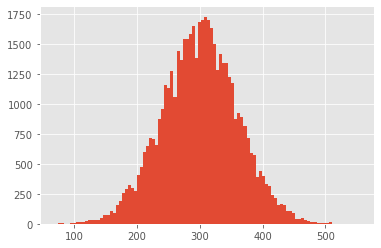

In [26]:
prediction = [i.cpu().numpy() for i in prediction]
prediction = np.array(prediction)
plt.hist(prediction, bins=100)

(array([1.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 8.000e+00,
        3.000e+00, 1.600e+01, 1.600e+01, 1.500e+01, 2.000e+01, 3.100e+01,
        3.500e+01, 3.200e+01, 3.100e+01, 5.200e+01, 7.000e+01, 7.700e+01,
        1.070e+02, 8.900e+01, 1.590e+02, 1.920e+02, 2.560e+02, 2.880e+02,
        3.220e+02, 2.980e+02, 2.740e+02, 4.090e+02, 4.750e+02, 5.970e+02,
        6.520e+02, 7.160e+02, 7.090e+02, 6.550e+02, 8.700e+02, 9.600e+02,
        1.153e+03, 1.135e+03, 1.273e+03, 1.057e+03, 1.440e+03, 1.368e+03,
        1.540e+03, 1.538e+03, 1.584e+03, 1.650e+03, 1.386e+03, 1.680e+03,
        1.697e+03, 1.726e+03, 1.697e+03, 1.632e+03, 1.496e+03, 1.279e+03,
        1.414e+03, 1.339e+03, 1.337e+03, 1.221e+03, 1.171e+03, 8.760e+02,
        9.270e+02, 8.880e+02, 8.110e+02, 7.140e+02, 5.920e+02, 5.730e+02,
        3.940e+02, 4.420e+02, 3.970e+02, 3.320e+02, 3.140e+02, 2.420e+02,
        2.110e+02, 1.550e+02, 1.670e+02, 1.550e+02, 1.030e+02, 1.040e+02,
        9.100e+01, 4.300e+01, 4.200e+0

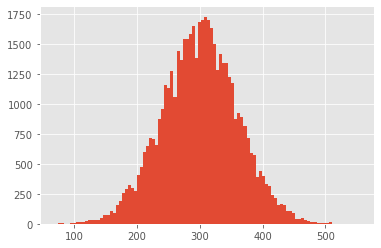

In [27]:
plt.hist(prediction, bins=100)

In [28]:
torch.save(model.state_dict(),'./waterRNN_600_states_sequence_3000')

In [29]:
np.save('./600_states_3000_length_result.npy', prediction)

In [30]:
space=np.linspace(-5,5,num=num_bins)

In [32]:
np.mean(space[prediction])


0.012543906510851167

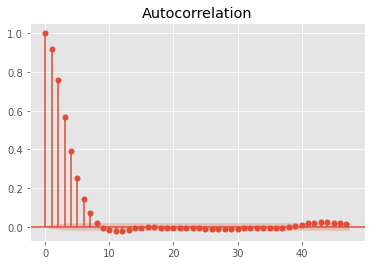

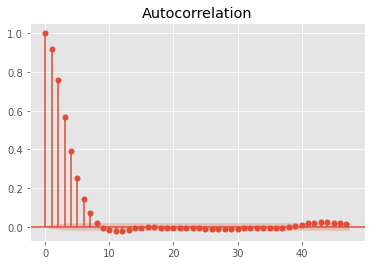

In [33]:
plot_acf(space[prediction])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

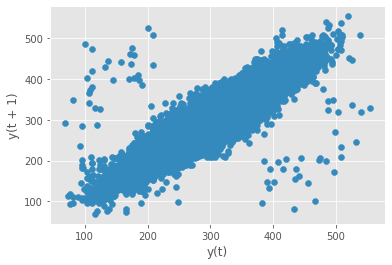

In [40]:
pd.plotting.lag_plot(pd.Series(prediction.reshape(-1)))

In [38]:
prediction.shape

(50000, 1)

In [ ]:
from scipy.fft import fft, fftfreq

In [ ]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 80000
# sample spacing

yf = fft(space[prediction])
xf = fftfreq(N)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
sp = np.fft.fft(space[prediction])
fq = np.fft.fftfreq(prediction.shape[0])
plt.plot(fq,sp.real, fq, sp.imag)

In [ ]:
prediction.shape

In [ ]:
plot_acf(space[prediction])

In [ ]:
pd.plotting.lag_plot(pd.Series(space[prediction.reshape(-1)]))

In [ ]:
pd.plotting.lag_plot(pd.Series(space[np.array(idx_2d).reshape(-1)]))